# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

In [1]:
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split


In [2]:
meses = {'jan': 1, 'fev':2, 'mar':3, 'abr': 4, 'mai':5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

caminho_bases = pathlib.Path('dataset')


base_airbnb = pd.DataFrame()

for arquivo in caminho_bases.iterdir():
    nome_mes = arquivo.name[:3]
    mes = meses[nome_mes]

    ano = arquivo.name[-8:]
    ano = int(ano.replace('.csv', ''))

    df = pd.read_csv(caminho_bases / arquivo.name, low_memory=False)
    df['ano'] = ano
    df['mes'] = mes
    base_airbnb = base_airbnb.append(df)


display(base_airbnb)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,14063,https://www.airbnb.com/rooms/14063,20180414160018,2018-04-14,Living in a Postcard,"Besides the most iconic's view, our apartment ...",NaN,"Besides the most iconic's view, our apartment ...",none,Best and favorite neighborhood of Rio. Perfect...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17878,https://www.airbnb.com/rooms/17878,20180414160018,2018-04-14,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for New Y...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for New Y...,none,This is the best spot in Rio. Everything happe...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24480,https://www.airbnb.com/rooms/24480,20180414160018,2018-04-14,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,The studio is located at Vinicius de Moraes St...,My studio is located in the best of Ipanema. ...,none,"The beach, the lagoon, Ipanema is a great loca...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25026,https://www.airbnb.com/rooms/25026,20180414160018,2018-04-14,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31560,https://www.airbnb.com/rooms/31560,20180414160018,2018-04-14,NICE & COZY 1BDR - IPANEMA BEACH,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,none,Die Nachbarschaft von Ipanema ist super lebend...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,38844730,https://www.airbnb.com/rooms/38844730,20190923212307,2019-09-24,TRANSAMERICA BARRA DA TIJUCA R IV,"Em estilo contemporâneo, o Transamerica Prime ...",NaN,"Em estilo contemporâneo, o Transamerica Prime ...",none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,15.0,0.0,0.0
34325,38846408,https://www.airbnb.com/rooms/38846408,20190923212307,2019-09-24,Alugo para o Rock in Rio,"Confortável apartamento, 2 quartos , sendo 1 s...",O apartamento estará com mobília completa disp...,"Confortável apartamento, 2 quartos , sendo 1 s...",none,"Muito próximo ao Parque Olímpico, local do eve...",...,2.0,2.0,1125.0,1125.0,2.0,1125.0,0.0,1.0,0.0,0.0
34326,38846703,https://www.airbnb.com/rooms/38846703,20190923212307,2019-09-24,Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA,Apartamento quarto e sala COMPLETO para curtas...,Espaço ideal para até 5 pessoas. Cama de casal...,Apartamento quarto e sala COMPLETO para curtas...,none,NaN,...,3.0,3.0,1125.0,1125.0,3.0,1125.0,0.0,23.0,6.0,0.0
34327,38847050,https://www.airbnb.com/rooms/38847050,20190923212307,2019-09-24,Cobertura Cinematografica,Cobertura alto nivel,NaN,Cobertura alto nivel,none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,1.0,0.0,0.0


### Agora vamos começar os tratamentos
_Como temos muitas colunas, nosso modelo pode acabar ficando muito lento.
_Além disso, uma análise rápida permite ver que várias colunas não são necessárias para nosso modelo de previsão, por isso, vamos excluir algumas
colunas da nossa base.
_Tipos de colunas que vamos excluir:
    
    1. IDs, Links e informações não relevantes para o modelo.
    2. Colunas repetidas ou extremamente parecidas com outras ( que não a mesma informação para o modelo. Ex: Data x Ano/Mês)
    3. Colunas preenchidas com texto livre --> Não rodaremos nenhuma análise de palavras ou algo do tipo. 
    4. Colunas em que todos ou quase todos os valores são iguais



    

In [3]:
print(list(base_airbnb.columns))
base_airbnb.head(1000).to_csv('primeiros_registros.csv', sep = ';')

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

### Depois da análise qualitativa das colunas , levando em conta os critérios explicados acima, ficamos com as seguintes colunas:

In [4]:
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_total_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']
base_airbnb = base_airbnb.loc[:,colunas]
print(list(base_airbnb.columns))
display(base_airbnb)


['host_response_time', 'host_response_rate', 'host_is_superhost', 'host_total_listings_count', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'ano', 'mes']


,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes
0,NaN,NaN,f,1.0,-22.946854,-43.182737,Apartment,Entire home/apt,4,1.0,...,9.0,9.0,9.0,9.0,9.0,f,f,strict_14_with_grace_period,2018,4
1,within an hour,100%,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1.0,...,9.0,10.0,10.0,9.0,9.0,t,f,strict,2018,4
2,within an hour,100%,f,1.0,-22.985698,-43.201935,Apartment,Entire home/apt,2,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
3,within an hour,100%,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
4,within an hour,100%,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,t,f,strict,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,within an hour,93%,f,0.0,-23.003180,-43.342840,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
34325,NaN,NaN,f,0.0,-22.966640,-43.393450,Apartment,Entire home/apt,4,2.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
34326,within a few hours,74%,f,32.0,-22.962080,-43.175520,Apartment,Entire home/apt,5,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9
34327,NaN,NaN,f,0.0,-23.003400,-43.341820,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9


### Tratar Valores Faltando

_ Visualizando os dados, percebemos que existe uma grande disparidade em dados faltantes. As colunas com mais de 300.000 valores NaN foram excluídas da análise.
_ Para as outras colunas, como temos muitos dados (mais de 900.000 linhas ) vamos excluir as linhas que contem dados NaN

In [5]:
for coluna in base_airbnb: # Este for é para tirar os valores NaN das colunas. isnull nos mostra os valores NaN, e o drop deleta os valores NaN, axis = 1 define a coluna.
    if (base_airbnb[coluna].isnull().sum() > 300000):
        base_airbnb = base_airbnb.drop(coluna, axis=1)
print(base_airbnb.isnull().sum())

host_is_superhost             460
host_total_listings_count     460
latitude                        0
longitude                       0
property_type                   0
room_type                       0
accommodates                    0
bathrooms                    1724
bedrooms                      850
beds                         2502
bed_type                        0
amenities                       0
price                           0
guests_included                 0
extra_people                    0
minimum_nights                  0
maximum_nights                  0
number_of_reviews               0
instant_bookable                0
is_business_travel_ready        0
cancellation_policy             0
ano                             0
mes                             0
dtype: int64


In [6]:
base_airbnb = base_airbnb.dropna() # dropna exclui as linhas com valores NaN

print(base_airbnb.shape) # O shape define quantas linhas e quantas colunas ativas.
print(base_airbnb.isnull().sum())

(897709, 23)
host_is_superhost            0
host_total_listings_count    0
latitude                     0
longitude                    0
property_type                0
room_type                    0
accommodates                 0
bathrooms                    0
bedrooms                     0
beds                         0
bed_type                     0
amenities                    0
price                        0
guests_included              0
extra_people                 0
minimum_nights               0
maximum_nights               0
number_of_reviews            0
instant_bookable             0
is_business_travel_ready     0
cancellation_policy          0
ano                          0
mes                          0
dtype: int64


### Verificar Tipos de Dados em cada coluna

In [7]:
print(base_airbnb.dtypes) # dtypes mostra o tipo de informação que tem cada uma das colunas.
print('-'*60)
display(base_airbnb.iloc[0])

host_is_superhost             object
host_total_listings_count    float64
latitude                     float64
longitude                    float64
property_type                 object
room_type                     object
accommodates                   int64
bathrooms                    float64
bedrooms                     float64
beds                         float64
bed_type                      object
amenities                     object
price                         object
guests_included                int64
extra_people                  object
minimum_nights                 int64
maximum_nights                 int64
number_of_reviews              int64
instant_bookable              object
is_business_travel_ready      object
cancellation_policy           object
ano                            int64
mes                            int64
dtype: object
------------------------------------------------------------


host_is_superhost                                                            f
host_total_listings_count                                                  1.0
latitude                                                            -22.946854
longitude                                                           -43.182737
property_type                                                        Apartment
room_type                                                      Entire home/apt
accommodates                                                                 4
bathrooms                                                                  1.0
bedrooms                                                                   0.0
beds                                                                       2.0
bed_type                                                              Real Bed
amenities                    {TV,Internet,"Air conditioning",Kitchen,Doorma...
price                                               

#### _Como o preço e extra people estão sendo reconhecidos como objetos ( ao invés de um float ) temos que mudar o tipo de variável coluna.

In [8]:
#price
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy = False) # astype(np.float32, copy = False) --> transforma em um numero inteiro com o código mais leve
#extra people
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy = False) # astype(np.float32, copy = False) --> transforma em um numero inteiro com o código mais leve

#Verificando os tipos
print(base_airbnb.dtypes)

C:\Users\PC\AppData\Local\Temp/ipykernel_6852/2772398204.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
C:\Users\PC\AppData\Local\Temp/ipykernel_6852/2772398204.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')


host_is_superhost             object
host_total_listings_count    float64
latitude                     float64
longitude                    float64
property_type                 object
room_type                     object
accommodates                   int64
bathrooms                    float64
bedrooms                     float64
beds                         float64
bed_type                      object
amenities                     object
price                        float32
guests_included                int64
extra_people                 float32
minimum_nights                 int64
maximum_nights                 int64
number_of_reviews              int64
instant_bookable              object
is_business_travel_ready      object
cancellation_policy           object
ano                            int64
mes                            int64
dtype: object


### Análise Exploratória e Tratar Outliers

- Vamos basicamente olhar feature por feature para:
    1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir
    
- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

MAS CUIDADO: não saia excluindo direto outliers, pense exatamente no que você está fazendo. Se não tem um motivo claro para remover o outlier, talvez não seja necessário e pode ser prejudicial para a generalização. Então tem que ter uma balança ai. Claro que você sempre pode testar e ver qual dá o melhor resultado, mas fazer isso para todas as features vai dar muito trabalho.

Ex de análise: Se o objetivo é ajudar a precificar um imóvel que você está querendo disponibilizar, excluir outliers em host_listings_count pode fazer sentido. Agora, se você é uma empresa com uma série de propriedades e quer comparar com outras empresas do tipo também e se posicionar dessa forma, talvez excluir quem tem acima de 6 propriedades tire isso do seu modelo. Pense sempre no seu objetivo

<AxesSubplot:>

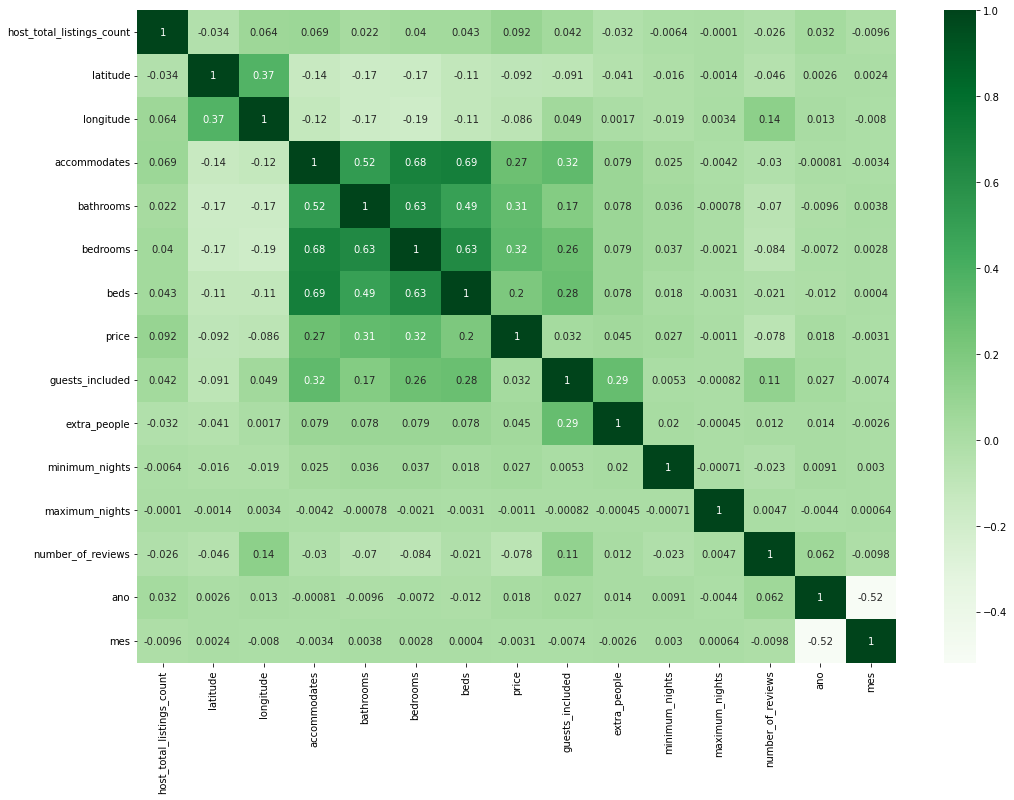

In [9]:
plt.figure(figsize=(17,12))
sns.heatmap(base_airbnb.corr(), annot=True, cmap = 'Greens') # anoot=True --> nos dá a descrição do gráfico, corr() --> nos da a correlação , cmap --> nos mostra a cor que queremos na análise.

#print(base_airbnb.corr())


### Definição de Funções para análise de Outliers
Vamos definir algumas funções para ajudar na análise de outliers das colunas

In [10]:
def limites (coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 -1.5 * amplitude, q3 + 1.5 * amplitude

def excluir_outliers (df, nome_coluna):
    qtde_linhas = df.shape[0]  # shape mostra as linhas e colunas excluídas.
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df, linhas_removidas

In [11]:
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(15,5) # Define o tamanho do gráfico, usamos esta função quando plotamos dois gráficos ao mesmo tempo, se fosse um gráfico seria -->  plt.figure(figsize=(17,12))
    sns.boxplot(x=coluna, ax = ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax = ax2)
    

def histograma (coluna):
    plt.figure(figsize=(15,5))
    sns.distplot(coluna, hist = True) # --> distplot é um gráfico de distribuição

def grafico_barra(coluna):
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x= coluna.value_counts().index , y= coluna.value_counts())
    ax.set_xlim(limites(coluna))


### price

C:\Users\PC\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


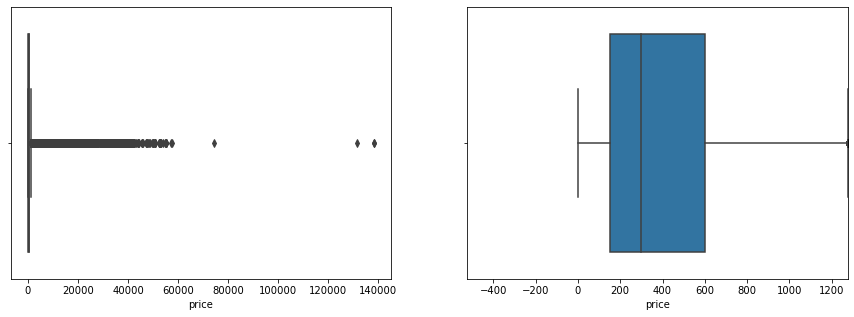

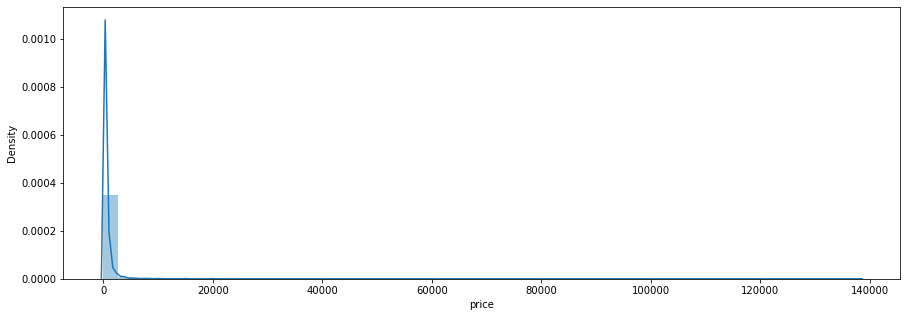

In [12]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

Como estamos construindo um modelo para imóveis comuns, acredito que os valores acima do limite superior serão apenas de apartamentos de altíssimo 
luxo, que não é nosso objetivo principal. Por isso, podemos excluir esses outliers.

In [13]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print(' {} linhas removidas '.format(linhas_removidas))

 87282 linhas removidas 


C:\Users\PC\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(810427, 23)


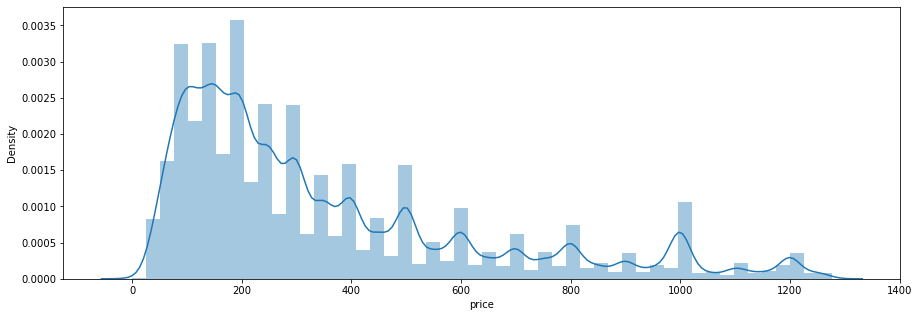

In [14]:
histograma(base_airbnb['price'])
print(base_airbnb.shape)

### extra_people

C:\Users\PC\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


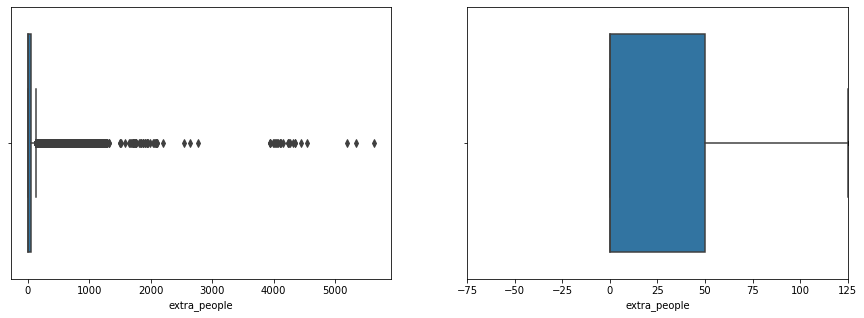

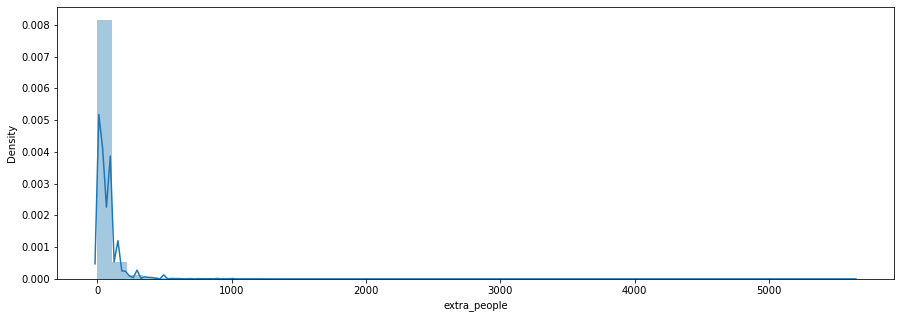

In [15]:
diagrama_caixa  (base_airbnb['extra_people'])
histograma  (base_airbnb['extra_people'])

In [16]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print(' {} linhas removidas '.format(linhas_removidas))

 59194 linhas removidas 


C:\Users\PC\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(751233, 23)


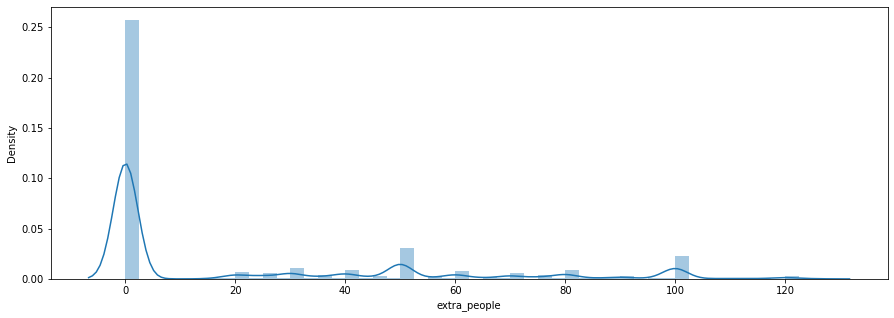

In [17]:
histograma(base_airbnb['extra_people'])
print(base_airbnb.shape)

### host_total_listings_count 

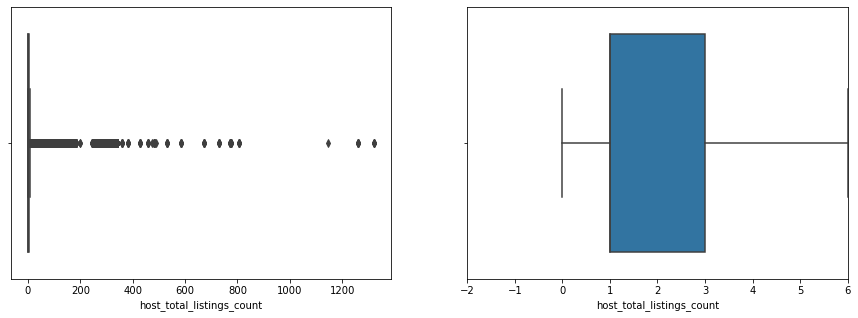

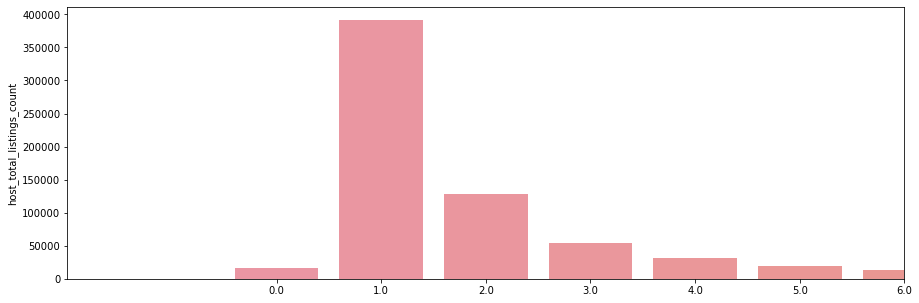

In [18]:
diagrama_caixa  (base_airbnb['host_total_listings_count'])
grafico_barra (base_airbnb['host_total_listings_count'])

Podemos excluir outliers , porque para o objetivo do nosso projeto, porque hosts com mais de 6 imóveis no airbnb não é o público alvo do nosso projeto (imagino que sejam imobiliários ou profissionais que gerenciam imóveis no airbnb)

In [19]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_total_listings_count')
print(' {} linhas removidas '.format(linhas_removidas))

 97723 linhas removidas 


### accommodates

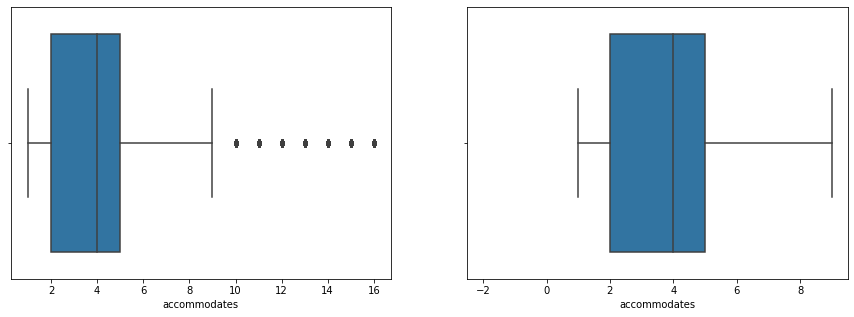

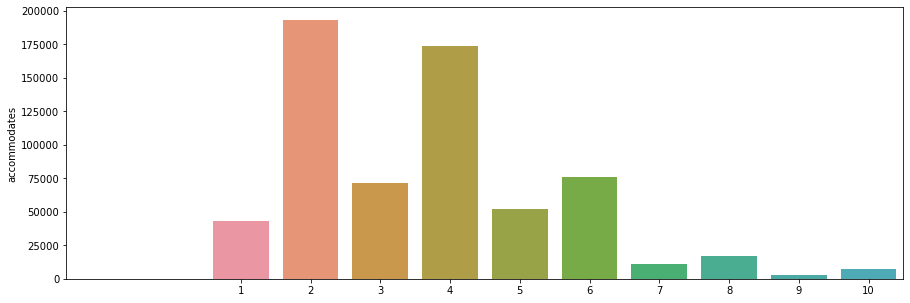

In [20]:
diagrama_caixa  (base_airbnb['accommodates'])
grafico_barra (base_airbnb['accommodates'])

In [21]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print(' {} linhas removidas '.format(linhas_removidas))

 13146 linhas removidas 


### bathooms

<AxesSubplot:ylabel='bathrooms'>

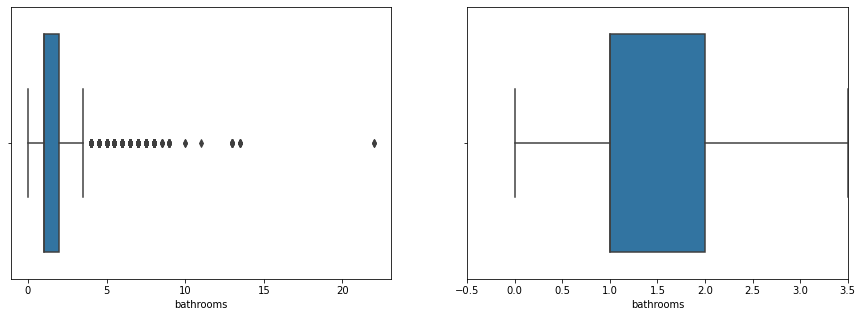

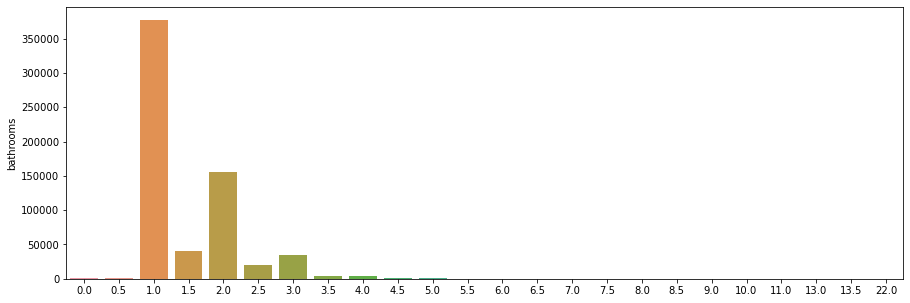

In [22]:
diagrama_caixa(base_airbnb['bathrooms'])
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts())

In [23]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print('{} linhas removidas'.format(linhas_removidas))

6894 linhas removidas


### bedrooms

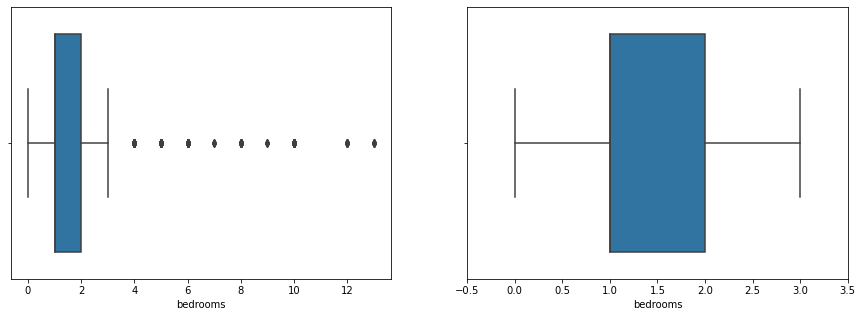

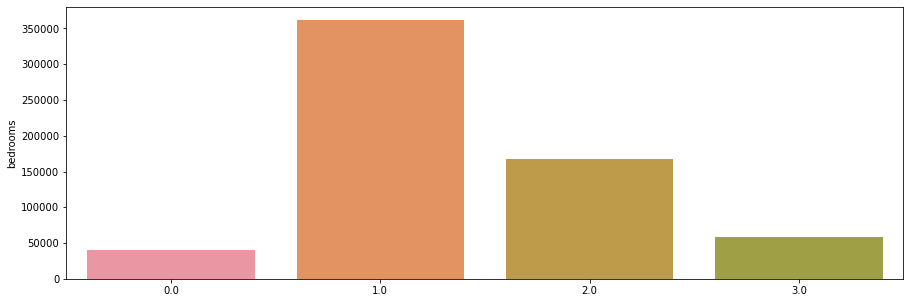

In [24]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

In [25]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print('{} linhas removidas'.format(linhas_removidas))

5482 linhas removidas


### beds

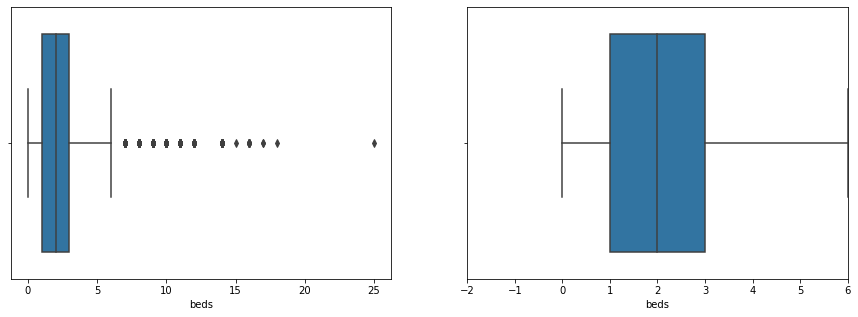

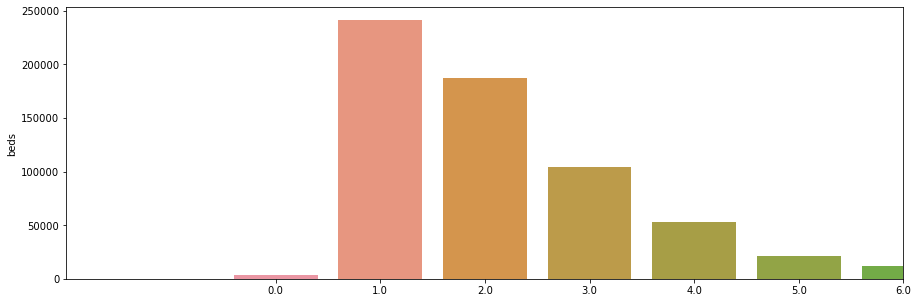

In [26]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

In [27]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print('{} linhas removidas'.format(linhas_removidas))

5622 linhas removidas


### guests_included

(1.0, 1.0)


<AxesSubplot:ylabel='guests_included'>

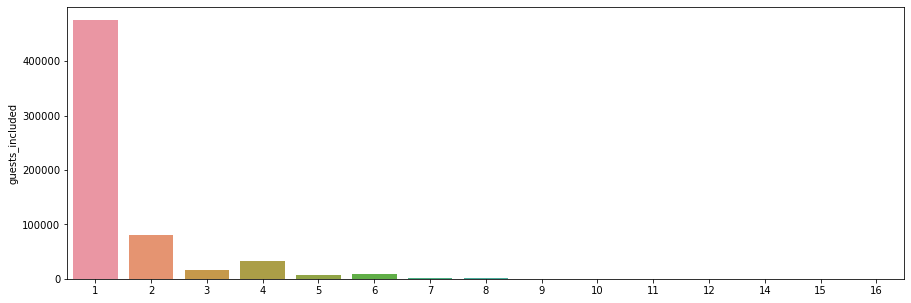

In [28]:
#diagrama_caixa(base_airbnb['guests_included'])
#grafico_barra(base_airbnb['guests_included'])
print(limites(base_airbnb['guests_included']))
plt.figure(figsize=(15,5))
sns.barplot(x = base_airbnb['guests_included'].value_counts().index, y = base_airbnb['guests_included'].value_counts())

Vamos remover essa feature da análise. Parece que os usuários do airbnb usam muito o valor padrão do airbnb como 1 guest included. Isso pode levar o nosso modelo a considerar uma feature que na verdade não é essencial para a definição do preço, por isso, me parece melhor excluir a coluna da análise

In [29]:
base_airbnb = base_airbnb.drop('guests_included', axis = 1)
base_airbnb.shape

(622366, 22)

### minimum_nights 

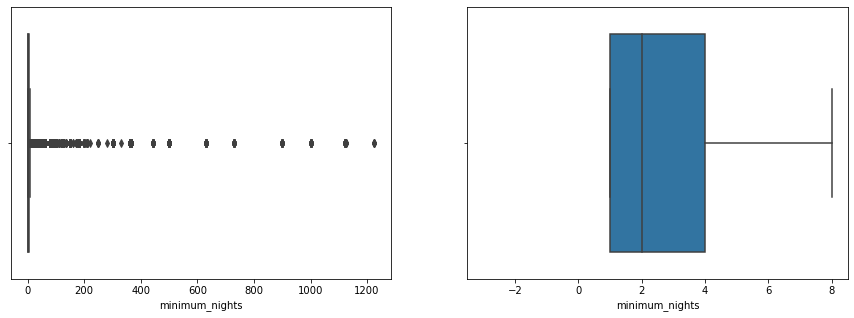

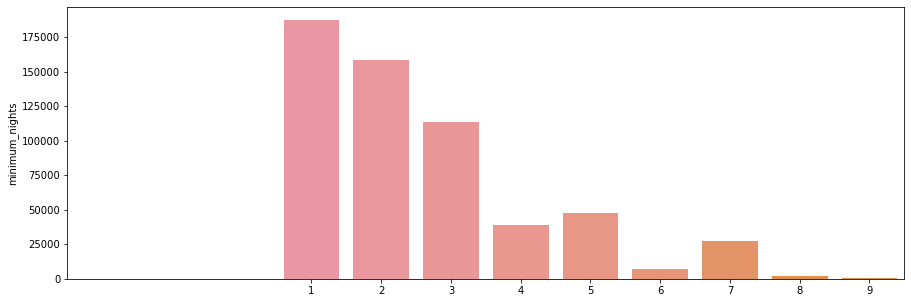

In [30]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

In [31]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print(' {} linhas removidas'.format(linhas_removidas))

 40383 linhas removidas


### maximum_nights 

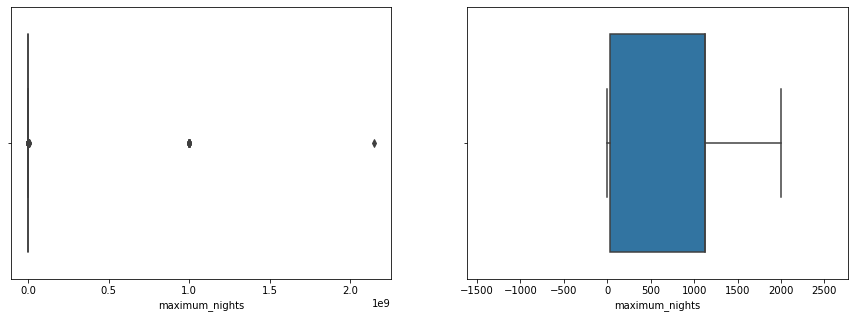

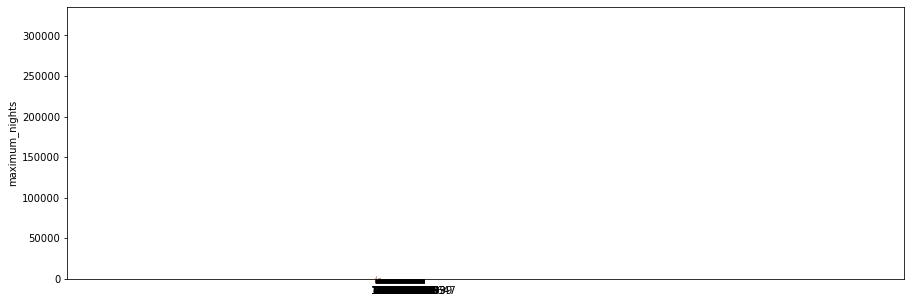

In [32]:
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

In [33]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
base_airbnb.shape 

(581983, 21)

### number_of_reviews              


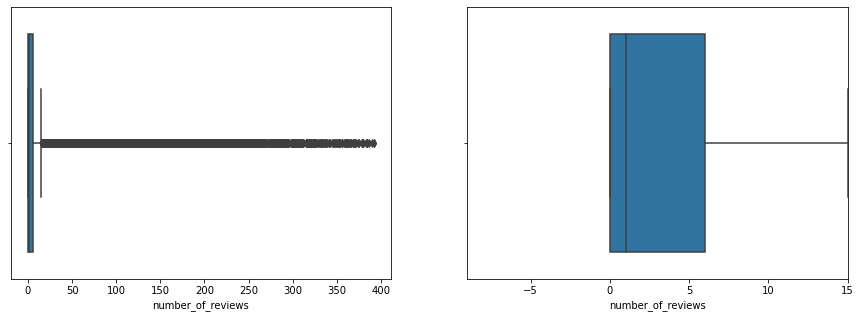

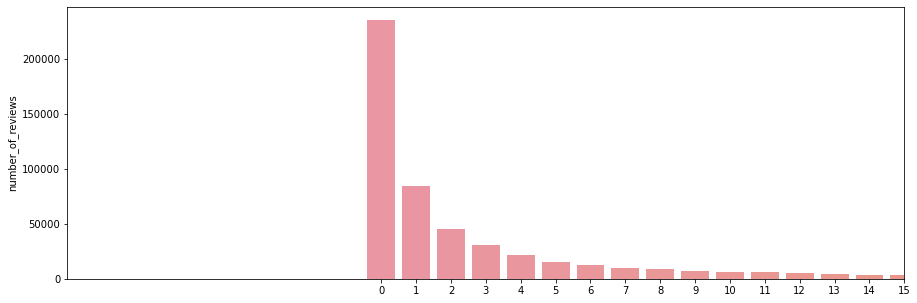

In [34]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

### Tratamento de Colunas de Valores de Texto

* property_type 

Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                      34
Resort    

C:\Users\PC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


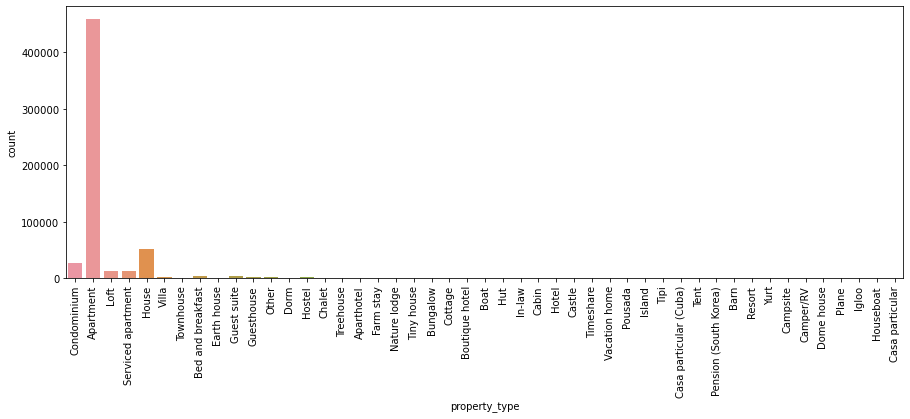

In [35]:
print(base_airbnb['property_type'].value_counts())
plt.figure(figsize=(15,5))
grafico = sns.countplot('property_type', data = base_airbnb) # sns.countplot('property_type, data = base_airbnb'), plota nosso gráfico e faz a contagem
grafico.tick_params(axis = 'x', rotation = 90) # --> grafico.tick_params(axis = 'x', rotation = 90) muda a posição do gráfico para melhor visualização

In [36]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

(581983, 20)

['Other', 'Villa', 'Townhouse', 'Aparthotel', 'Chalet', 'Earth house', 'Tiny house', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Castle', 'Treehouse', 'Island', 'Boat', 'Hut', 'Campsite', 'Resort', 'Camper/RV', 'Yurt', 'Tent', 'Tipi', 'Barn', 'Farm stay', 'Pension (South Korea)', 'Dome house', 'Igloo', 'In-law', 'Vacation home', 'Timeshare', 'Pousada', 'Houseboat', 'Casa particular', 'Plane']
Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Outros                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: property_type, dtype: int64


C:\Users\PC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


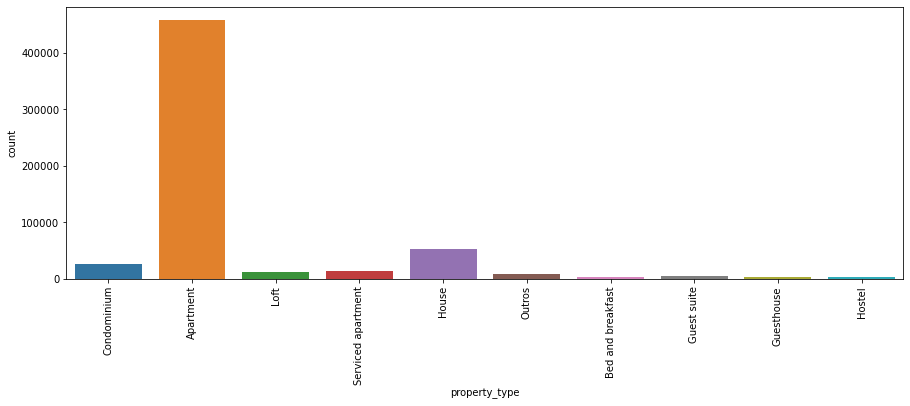

In [37]:
tabela_tipos_casa = base_airbnb['property_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] < 2000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['property_type'] == tipo, 'property_type'] = 'Outros' 

print(base_airbnb['property_type'].value_counts())
plt.figure(figsize=(15,5))
grafico = sns.countplot('property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation = 90)

 - room_type

Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: room_type, dtype: int64


C:\Users\PC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


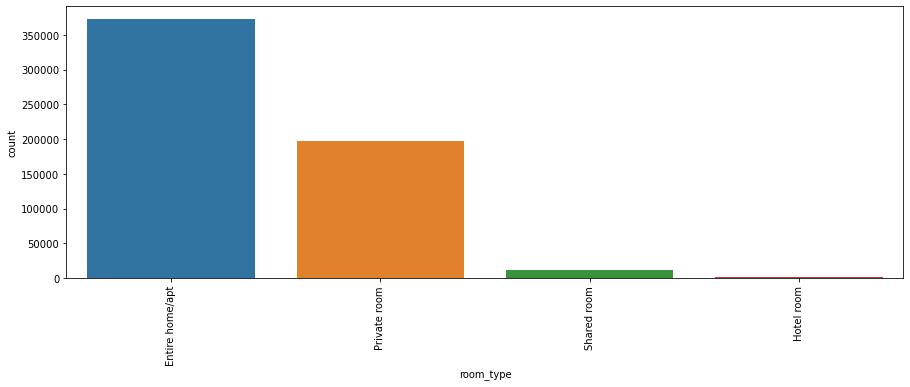

In [38]:
print(base_airbnb['room_type'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot('room_type', data = base_airbnb)
grafico.tick_params(axis='x', rotation = 90)

- bed_type   

Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: bed_type, dtype: int64


C:\Users\PC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


['Pull-out Sofa', 'Futon', 'Airbed', 'Couch']
Real Bed    570643
Outros       11340
Name: bed_type, dtype: int64


C:\Users\PC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


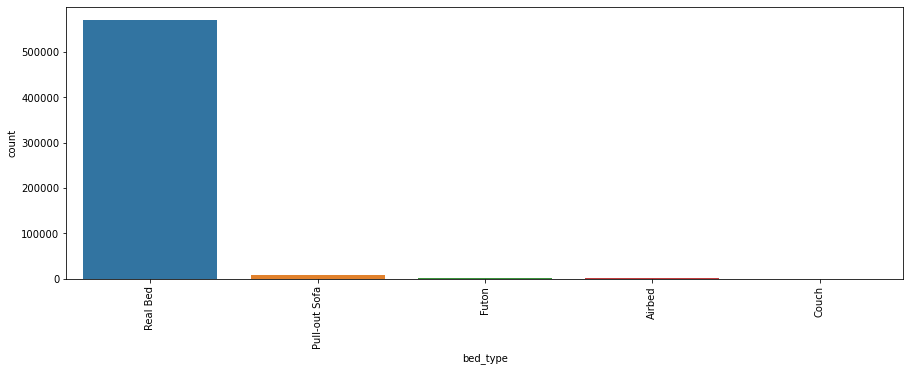

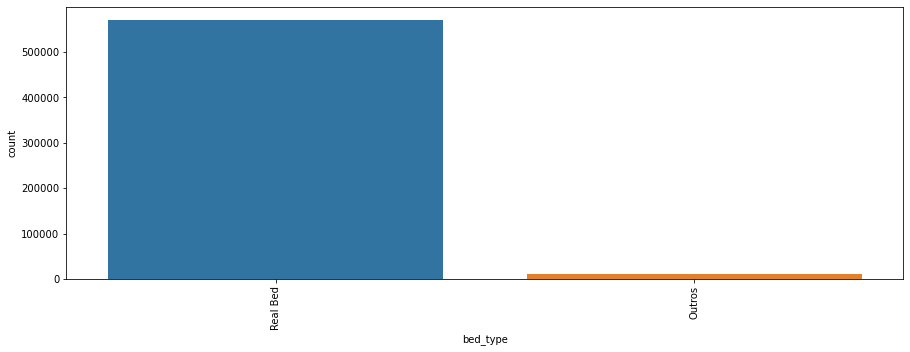

In [39]:
print(base_airbnb['bed_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('bed_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

# Agrupando categorias de bed_type

tabela_bed = base_airbnb['bed_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_bed.index:
    if tabela_bed [tipo] < 10000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['bed_type'] == tipo, 'bed_type'] = 'Outros'

print(base_airbnb['bed_type'].value_counts())
plt.figure(figsize=(15,5))
grafico = sns.countplot('bed_type', data = base_airbnb)
grafico.tick_params(axis = 'x', rotation = 90)

- cancellation_policy

flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: cancellation_policy, dtype: int64


C:\Users\PC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


['strict', 'super_strict_60', 'super_strict_30']
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9863
Name: cancellation_policy, dtype: int64


C:\Users\PC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


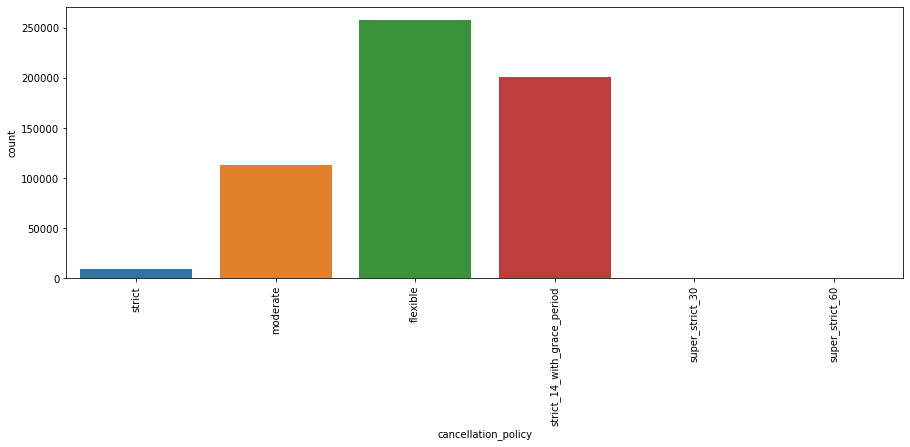

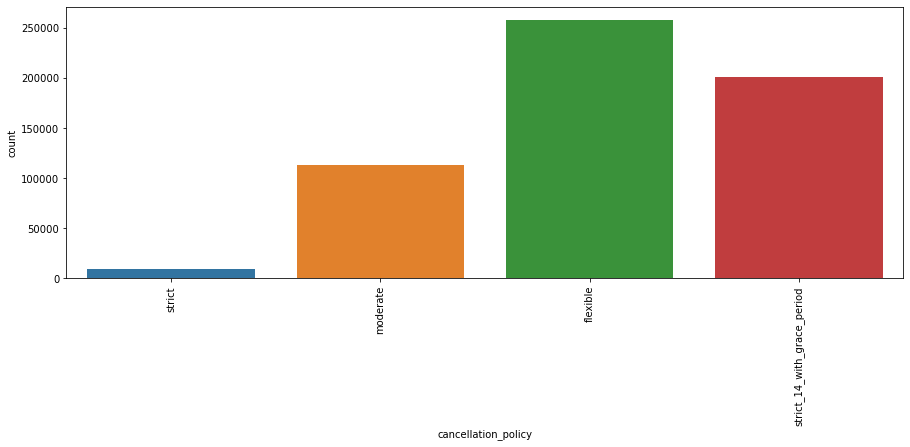

In [40]:
print(base_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot('cancellation_policy', data = base_airbnb)
grafico.tick_params(axis = 'x' , rotation = 90)

# Agrupando categorias de cancellation_policy

tabela_cancellation = base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar = []

for tipo in tabela_cancellation.index:
    if tabela_cancellation[tipo] < 10000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['cancellation_policy'] == tipo, 'cancellation_policy'] = 'strict' 

print(base_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize=(15,5))
grafico = sns.countplot('cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation = 90)



 - amenities 

Como temos uma diversidade muito grande de amenities e, às vezes, as mesmas amenities podem ser escritas de forma diferente, vamos avaliar a quantidade de amenities como o parâmetro para o nosso modelo

In [41]:
print(base_airbnb['amenities'].iloc[1].split(',')) # split(',') organiza nosso texto embaralhado por por vírgula
print(len(base_airbnb['amenities'].iloc[1].split(',')))

base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len) # .apply(len) mostra o tamanho da lista

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', 'Doorman', 'Elevator', '"Buzzer/wireless intercom"', '"Family/kid friendly"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"}']
14


In [42]:
base_airbnb = base_airbnb.drop('amenities', axis=1)
base_airbnb.shape

(581983, 20)

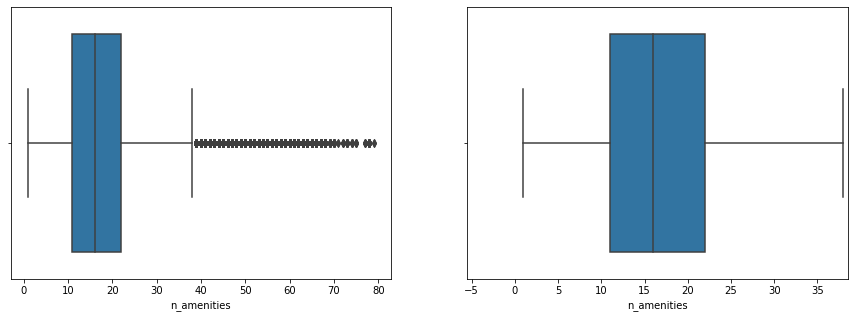

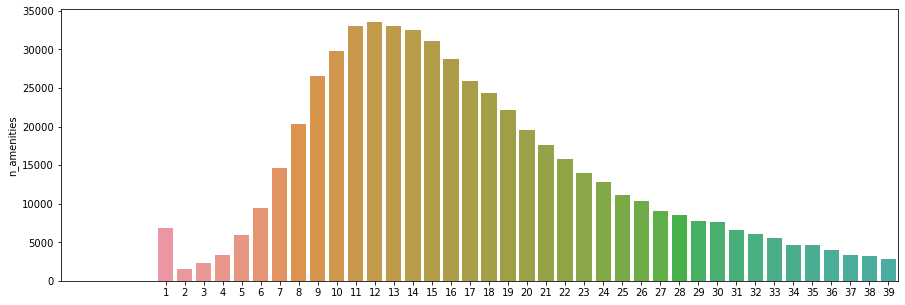

In [43]:
diagrama_caixa(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

In [44]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'n_amenities')
print( '{} linhas removidas'.format(linhas_removidas))

24343 linhas removidas


### Visualização de Mapa das Propriedades

In [45]:
amostra = base_airbnb.sample(n=50000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}
mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude',z='price', radius=2.5,
                        center=centro_mapa, zoom=10,
                        mapbox_style='stamen-terrain')
mapa.show()

### Encoding
Precisamos ajustar as features para facilitar o trabalho do modelo futuro (features de categoria , true e false, etc.)
- Features de Valores True ou False, vamos substituir True por 1 e False por 0.
- Features de Categoria (features em que os valores da coluna são textos) vamos utilizar o método de encoding de variáveis dummies

In [46]:
colunas_tf = ['host_is_superhost','instant_bookable','is_business_travel_ready']
base_airbnb_cod = base_airbnb.copy()
for coluna in colunas_tf:
    base_airbnb_cod.loc[ base_airbnb_cod[coluna] == 't', coluna] = 1
    base_airbnb_cod.loc[ base_airbnb_cod[coluna] == 'f', coluna] = 0

In [47]:
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy' ]
base_airbnb_cod = pd.get_dummies(data = base_airbnb_cod, columns = colunas_categorias)
display(base_airbnb_cod.head())

,host_is_superhost,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,extra_people,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Outros,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period
1,1,2.0,-22.965919,-43.178962,5,1.0,2.0,2.0,270.0,51.0,...,1,0,0,0,0,1,0,0,1,0
3,0,3.0,-22.977117,-43.190454,3,1.0,1.0,2.0,161.0,45.0,...,1,0,0,0,0,1,0,0,1,0
4,1,1.0,-22.983024,-43.214270,3,1.0,1.0,2.0,222.0,68.0,...,1,0,0,0,0,1,0,0,1,0
5,1,1.0,-22.988165,-43.193588,3,1.5,1.0,2.0,308.0,86.0,...,1,0,0,0,0,1,0,0,1,0
6,1,1.0,-22.981269,-43.190457,2,1.0,1.0,2.0,219.0,80.0,...,1,0,0,0,0,1,0,0,1,0


### Modelo de Previsão

- Métricas de Avaliação

In [48]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo {nome_modelo} : \nR2: {r2:.2%} \nRSME: {RSME: .2f}'


- Escolha dos Modelos a Serem Testados
1. RandomForest
2. LinearRegression
3. Extra Tree

In [49]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = {'RandomForest': modelo_rf ,
'LinearRegression': modelo_lr ,
'ExtraTrees': modelo_et,}

y = base_airbnb_cod['price']
x = base_airbnb_cod.drop('price', axis = 1)

- Separa os dados em treino e teste + Treino do Modelo

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

for nome_modelo, modelo in modelos.items():
    #treinar
    modelo.fit(x_train, y_train)
    #testar
    previsao = modelo.predict(x_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))
    

Modelo RandomForest : 
R2: 97.25% 
RSME:  44.00
Modelo LinearRegression : 
R2: 32.70% 
RSME:  217.54
Modelo ExtraTrees : 
R2: 97.51% 
RSME:  41.81


### Análise do Melhor Modelo

In [51]:
for nome_modelo, modelo in modelos.items():
    #testar
    previsao = modelo.predict(x_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))
    

Modelo RandomForest : 
R2: 97.25% 
RSME:  44.00
Modelo LinearRegression : 
R2: 32.70% 
RSME:  217.54
Modelo ExtraTrees : 
R2: 97.51% 
RSME:  41.81


- Modelo Escolhido como Melhor Modelo: ExtraTressRegressor

    Esse foi o modelo com maior valor de R² e ao mesmo tempo o menor valor de RSME. Como não tivemos uma grande diferença de velocidade de treino e de previsão desse modelo com o modelo de RandomForest (que teve resultados próximos de R² e RSME), vamos escolher o Modelo ExtraTrees.
    
    O modelo de regressão linear não obteve um resultado satisfatório, com valores de R² e RSME muito piores do que os outros 2 modelos.
    
- Resultados das Métricas de Avaliações no Modelo Vencedor:<br>
Modelo ExtraTrees:<br>
R²:97.51%<br>
RSME:41.81

### Ajustes e Melhorias no Melhor Modelo

,0
bedrooms,0.109010
latitude,0.104385
longitude,0.100857
n_amenities,0.089072
extra_people,0.087379
accommodates,0.071738
bathrooms,0.071723
room_type_Entire home/apt,0.069348
minimum_nights,0.065082
beds,0.052923


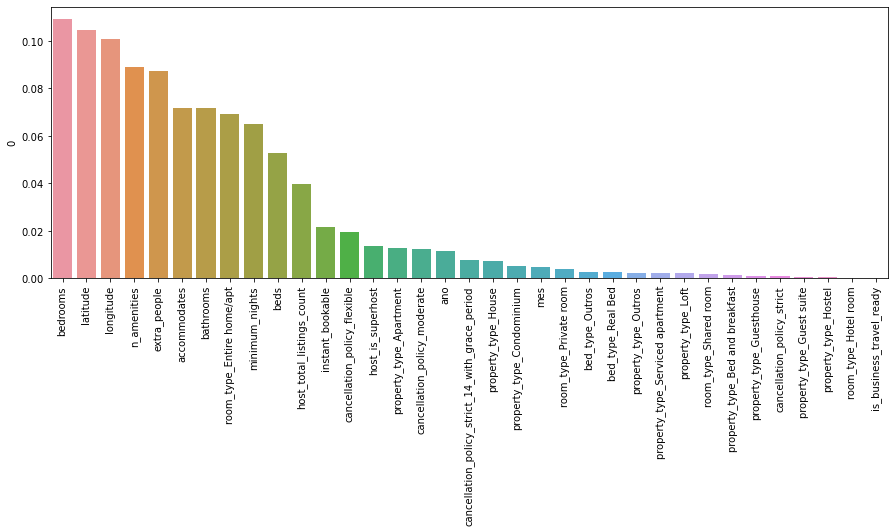

In [52]:
#print(modelo_et.feature_importances_)
#print(x_train.columns)
importancia_features = pd.DataFrame(modelo_et.feature_importances_, x_train.columns)
importancia_features = importancia_features.sort_values(by = 0, ascending = False) # para colocar em ordem decrescente
display(importancia_features)
plt.figure(figsize = (15,5))
ax = sns.barplot(x = importancia_features.index, y = importancia_features[0])
ax.tick_params(axis = 'x', rotation = 90)


### Ajustes Finais no Modelo

- is_business_travel_ready não parece ter muito impacto no nosso modelo. Por isso, para chegar em um modelo mais simples, vamos excluir essa feature e testar o modelo sem ela.

In [53]:
print(base_airbnb_cod.columns)

Index(['host_is_superhost', 'host_total_listings_count', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'extra_people', 'minimum_nights', 'instant_bookable',
       'is_business_travel_ready', 'ano', 'mes', 'n_amenities',
       'property_type_Apartment', 'property_type_Bed and breakfast',
       'property_type_Condominium', 'property_type_Guest suite',
       'property_type_Guesthouse', 'property_type_Hostel',
       'property_type_House', 'property_type_Loft', 'property_type_Outros',
       'property_type_Serviced apartment', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'bed_type_Outros', 'bed_type_Real Bed',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period'],
      dtype='object')


In [54]:
base_airbnb_cod = base_airbnb_cod.drop('is_business_travel_ready', axis=1)


y = base_airbnb_cod['price'] # este é o nosso modelo
x = base_airbnb_cod.drop('price', axis=1) # este é o nosso modelo sem a coluna de price

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)


modelo_et.fit(x_train, y_train)   
previsao = modelo_et.predict(x_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))
    


Modelo ExtraTrees : 
R2: 97.51% 
RSME:  41.80


In [55]:
base_teste = base_airbnb_cod.copy()
for coluna in base_teste:
    if 'bed_type' in coluna:
        base_teste = base_teste.drop(coluna, axis = 1)
print(base_teste.columns)

y = base_teste['price']
x = base_teste.drop('price', axis = 1)

x_train, x_test , y_train, y_test = train_test_split(x, y, random_state= 10)

modelo_et.fit(x_train, y_train )
previsao = modelo_et.predict(x_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))


Index(['host_is_superhost', 'host_total_listings_count', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'extra_people', 'minimum_nights', 'instant_bookable', 'ano', 'mes',
       'n_amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Outros', 'property_type_Serviced apartment',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period'],
      dtype='object')
Modelo ExtraTrees : 
R2: 97.49% 
RSME:  42.00


In [56]:
print(previsao)

[100.99 998.53 249.18 ... 123.34 282.1  119.89]


# Deploy do Projeto

- Passo 1 -> Criar arquivo do Modelo (joblib)<br>
- Passo 2 -> Escolher a forma de deploy:
    - Arquivo Executável + Tkinter
    - Deploy em Microsite (Flask)
    - Deploy apenas para uso direto Streamlit
- Passo 3 -> Outro arquivo Python (pode ser Jupyter ou PyCharm)
- Passo 4 -> Importar streamlit e criar código
- Passo 5 -> Atribuir ao botão o carregamento do modelo
- Passo 6 -> Deploy feito

In [57]:
x['price'] = y
x.to_csv('dados.csv')

In [58]:
import joblib
joblib.dump(modelo_et, 'modelo.joblib') # joblib.dump (variável, nome do arquivo que você quer salvar) -- > pega um objeto em código python e transforma em um arquivo

['modelo.joblib']